Complex Total Variation Denoising (ADMM)
========================================

This example demonstrates solution of a problem of the form

  $$\argmin_{\mathbf{x}} \; f(\mathbf{x}) + g(C(\mathbf{x})) \;,$$

where $C$ is a nonlinear operator, via non-linear PDHG
<cite data-cite="valkonen-2014-primal"/>. The example problem represents total
variation (TV) denoising applied to a complex image with piece-wise
smooth magnitude and non-smooth phase. The appropriate TV denoising
formulation for this problem is

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda \| C(\mathbf{x}) \|_{2,1} \;,$$

where $\mathbf{y}$ is the measurement, $\|\cdot\|_{2,1}$ is the
$\ell_{2,1}$ mixed norm, and $C$ is a non-linear operator that applies a
linear difference operator to the magnitude of a complex array. The
standard TV solution, which is also computed for comparison purposes,
gives very poor results since the difference is applied independently to
real and imaginary components of the complex image.

In [1]:
import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, operator, plot
from scico.optimize import PDHG
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_mag = snp.pad(discrete_phantom(phantom, 240), 8) + 1.0
x_mag /= x_mag.max()
# Create reference image with structured magnitude and random phase
x_gt = x_mag * snp.exp(-1j * scico.random.randn(x_mag.shape, seed=0)[0])
x_gt = jax.device_put(x_gt)  # convert to jax type, push to device

Add noise to create a noisy test image.

In [3]:
σ = 0.25  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=1, dtype=snp.complex64)
y = x_gt + σ * noise

Denoise with standard total variation.

In [4]:
λ_tv = 6e-2
f = loss.SquaredL2Loss(y=y)
g = λ_tv * functional.L21Norm()
# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, input_dtype=snp.complex64, append=0)
solver_tv = PDHG(
    f=f,
    g=g,
    C=C,
    tau=4e-1,
    sigma=4e-1,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
x_tv = solver_tv.solve()
hist_tv = solver_tv.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  2.24e+00  1.066e+04  1.373e+02  3.829e+01
  10  3.37e+00  3.814e+03  4.043e+00  1.280e-02
  20  3.42e+00  3.806e+03  1.398e-01  6.217e-04
  30  3.47e+00  3.806e+03  4.831e-03  4.037e-05


  40  3.52e+00  3.806e+03  1.670e-04  2.078e-05
  50  3.57e+00  3.806e+03  7.106e-06  1.361e-05
  60  3.62e+00  3.806e+03  1.948e-06  1.236e-05
  70  3.67e+00  3.806e+03  1.580e-06  1.228e-05
  80  3.71e+00  3.806e+03  1.532e-06  1.227e-05


  90  3.75e+00  3.806e+03  1.563e-06  1.222e-05
 100  3.78e+00  3.806e+03  1.511e-06  1.231e-05
 110  3.81e+00  3.806e+03  1.545e-06  1.223e-05
 120  3.84e+00  3.806e+03  1.547e-06  1.225e-05
 130  3.87e+00  3.806e+03  1.539e-06  1.227e-05
 140  3.90e+00  3.806e+03  1.524e-06  1.227e-05


 150  3.93e+00  3.806e+03  1.537e-06  1.221e-05
 160  3.96e+00  3.806e+03  1.511e-06  1.230e-05
 170  3.99e+00  3.806e+03  1.540e-06  1.225e-05
 180  4.02e+00  3.806e+03  1.533e-06  1.226e-05
 190  4.05e+00  3.806e+03  1.542e-06  1.227e-05
 199  4.08e+00  3.806e+03  1.527e-06  1.223e-05


Denoise with non-linear total variation.

In [5]:
λ_nltv = 2e-1
g = λ_nltv * functional.L21Norm()
# Redefine C for real input (now applied to magnitude of a complex array)
C = linop.FiniteDifference(input_shape=x_gt.shape, input_dtype=snp.float32, append=0)
# Operator computing differences of absolute values
D = C @ operator.Abs(input_shape=x_gt.shape, input_dtype=snp.complex64)
solver_nltv = PDHG(
    f=f,
    g=g,
    C=D,
    tau=4e-1,
    sigma=4e-1,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
x_nltv = solver_nltv.solve()
hist_nltv = solver_nltv.itstat_object.history(transpose=True)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.25e+00  1.056e+04  1.373e+02  5.088e+01


  10  1.79e+00  1.214e+03  4.852e+00  2.524e+00
  20  1.87e+00  1.164e+03  4.825e-01  1.097e+00


  30  1.95e+00  1.154e+03  2.040e-01  7.021e-01
  40  2.03e+00  1.150e+03  1.215e-01  5.130e-01
  50  2.08e+00  1.148e+03  8.232e-02  4.049e-01


  60  2.13e+00  1.146e+03  6.026e-02  3.324e-01
  70  2.18e+00  1.145e+03  4.652e-02  2.803e-01
  80  2.23e+00  1.145e+03  3.700e-02  2.420e-01
  90  2.28e+00  1.144e+03  3.054e-02  2.120e-01
 100  2.32e+00  1.144e+03  2.535e-02  1.885e-01


 110  2.37e+00  1.143e+03  2.157e-02  1.695e-01
 120  2.42e+00  1.143e+03  1.869e-02  1.536e-01
 130  2.47e+00  1.143e+03  1.618e-02  1.401e-01
 140  2.52e+00  1.143e+03  1.422e-02  1.286e-01


 150  2.56e+00  1.142e+03  1.237e-02  1.190e-01
 160  2.61e+00  1.142e+03  1.121e-02  1.105e-01
 170  2.66e+00  1.142e+03  9.792e-03  1.035e-01
 180  2.71e+00  1.142e+03  8.941e-03  9.702e-02


 190  2.76e+00  1.142e+03  8.485e-03  9.119e-02
 199  2.80e+00  1.142e+03  7.614e-03  8.665e-02


Plot results.

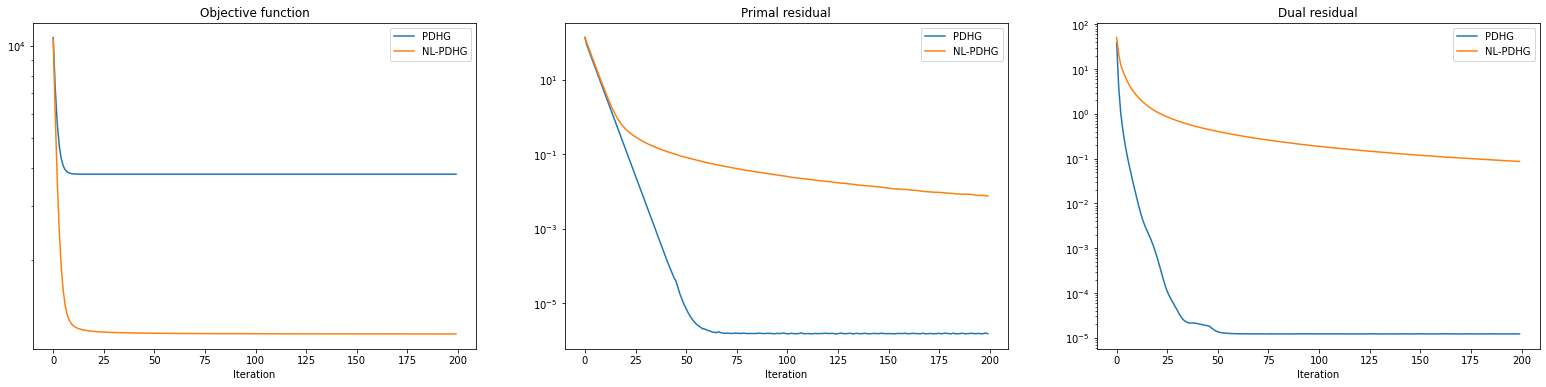

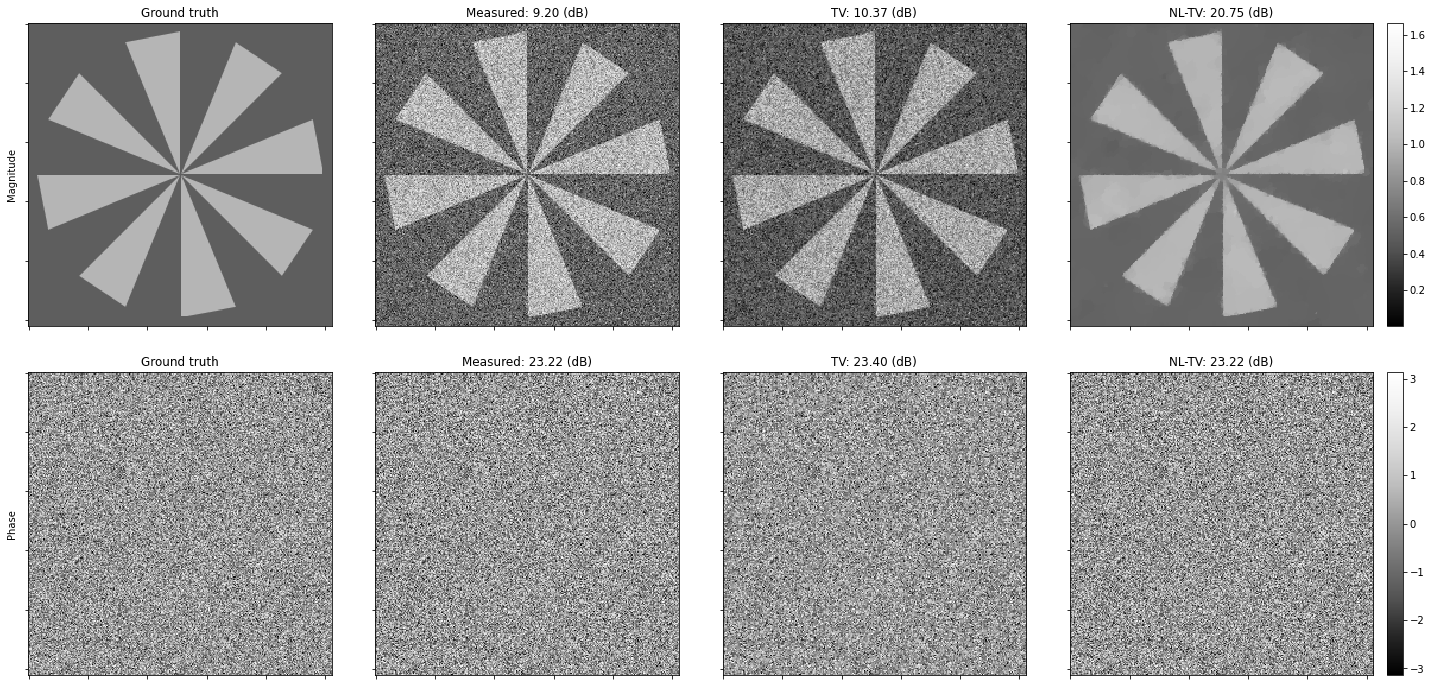

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_tv.Objective, hist_nltv.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("PDHG", "NL-PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_tv.Prml_Rsdl, hist_nltv.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("PDHG", "NL-PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_tv.Dual_Rsdl, hist_nltv.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("PDHG", "NL-PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()


fig, ax = plot.subplots(nrows=2, ncols=4, figsize=(20, 10))
norm = plot.matplotlib.colors.Normalize(
    vmin=min(snp.abs(x_gt).min(), snp.abs(y).min(), snp.abs(x_tv).min(), snp.abs(x_nltv).min()),
    vmax=max(snp.abs(x_gt).max(), snp.abs(y).max(), snp.abs(x_tv).max(), snp.abs(x_nltv).max()),
)
plot.imview(snp.abs(x_gt), title="Ground truth", cbar=None, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(
    snp.abs(y),
    title="Measured: %.2f (dB)" % metric.psnr(snp.abs(x_gt), snp.abs(y)),
    cbar=None,
    fig=fig,
    ax=ax[0, 1],
    norm=norm,
)
plot.imview(
    snp.abs(x_tv),
    title="TV: %.2f (dB)" % metric.psnr(snp.abs(x_gt), snp.abs(x_tv)),
    cbar=None,
    fig=fig,
    ax=ax[0, 2],
    norm=norm,
)
plot.imview(
    snp.abs(x_nltv),
    title="NL-TV: %.2f (dB)" % metric.psnr(snp.abs(x_gt), snp.abs(x_nltv)),
    cbar=None,
    fig=fig,
    ax=ax[0, 3],
    norm=norm,
)
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[0, 3].get_images()[0], cax=cax)
norm = plot.matplotlib.colors.Normalize(
    vmin=min(snp.angle(x_gt).min(), snp.angle(x_tv).min(), snp.angle(x_nltv).min()),
    vmax=max(snp.angle(x_gt).max(), snp.angle(x_tv).max(), snp.angle(x_nltv).max()),
)
plot.imview(
    snp.angle(x_gt),
    title="Ground truth",
    cbar=None,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    snp.angle(y),
    title="Measured: %.2f (dB)" % metric.psnr(snp.angle(x_gt), snp.angle(y)),
    cbar=None,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
plot.imview(
    snp.angle(x_tv),
    title="TV: %.2f (dB)" % metric.psnr(snp.angle(x_gt), snp.angle(x_tv)),
    cbar=None,
    fig=fig,
    ax=ax[1, 2],
    norm=norm,
)
plot.imview(
    snp.angle(x_nltv),
    title="NL-TV: %.2f (dB)" % metric.psnr(snp.angle(x_gt), snp.angle(x_nltv)),
    cbar=None,
    fig=fig,
    ax=ax[1, 3],
    norm=norm,
)
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[1, 3].get_images()[0], cax=cax)
ax[0, 0].set_ylabel("Magnitude")
ax[1, 0].set_ylabel("Phase")
fig.tight_layout()
fig.show()